In [55]:
%pip install -q --upgrade sentence-transformers
%pip install -q --upgrade faiss-cpu
%pip install -q --upgrade faiss-gpu
%pip install -q --upgrade scikit-learn
%pip install -q --upgrade pandas
%pip install -q --upgrade numpy
%pip install -q --upgrade matplotlib
import pandas as pd
from sklearn.ensemble import IsolationForest
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
import os
import faiss
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings("ignore")
ANOMALY_LABELS = ["is_fraud"]
BINARY_LABEL = "is_fraud"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:

# Choose between OpenAI or AzureOpenAI
USE_AZURE = False  # Set to True if running experiments at work

if USE_AZURE:
    from openai import AzureOpenAI
    client = AzureOpenAI(
        azure_endpoint="PUT ENDPOINT HERE",
        api_key="PUT API KEY HERE",
        api_version="PUT VERSION HERE"
    )
    deployment_name = "PUT DEPLOYMENT NAME HERE"
else:
    import openai
    client = openai.OpenAI(api_key="PUT CHATGPT API KEY HERE")  # Replace with your actual key or set as env var
    deployment_name = "gpt-4o"


## 📦 Dataset Loader and Preprocessing

This section defines functions for:
- Loading different fraud-related datasets
- Splitting into train/test sets
- Balancing the data for anomaly detection (important since fraud is rare!)


In [57]:
# === Dataset Loader + Test ===

def load_dataset(name):
    """
    Loads dataset based on name and updates anomaly label type.
    Returns: dataframe, domain name
    """
    global ANOMALY_LABELS

    if name == "credit":
        df = pd.read_csv("creditcard.csv", index_col=0)
        domain = "credit"
        ANOMALY_LABELS = ["Class"]
    elif name == "insurance":
        df = pd.read_csv("insurance_claim.csv", index_col=0)
        domain = "insurance"
        ANOMALY_LABELS = ["insurance_claim"]
    elif name == "fraudtest":
        df = pd.read_csv("fraudTest.csv", index_col=0)
        domain = "fraudtest"
        ANOMALY_LABELS = ["is_fraud"]
    else:
        raise ValueError(f"❌ Unknown dataset: {name}")
    
    print(f"📄 Loaded dataset: '{name}' | Domain: {domain} | Shape: {df.shape}")
    print(f"🔎 Anomaly label column: {ANOMALY_LABELS[0]}")
    return df, domain

# === Run a test load on "fraudtest" dataset ===
df, domain = load_dataset("fraudtest")

# Show a preview of the data
print("\n🔍 Sample data:")
display(df.head())


📄 Loaded dataset: 'fraudtest' | Domain: fraudtest | Shape: (555719, 22)
🔎 Anomaly label column: is_fraud

🔍 Sample data:


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [58]:
# === Clean up merchant names ===

if "merchant" in df.columns:
    df["merchant"] = df["merchant"].str.replace("^fraud_", "", regex=True)
    print("🧽 Cleaned 'merchant' column — removed misleading 'fraud_' prefix.")
else:
    print("⚠️ No 'merchant' column found in the dataset.")

# Show a few example merchant names
print("\n🛍️ Sample merchant names:")
print(df["merchant"].dropna().unique()[:10])


🧽 Cleaned 'merchant' column — removed misleading 'fraud_' prefix.

🛍️ Sample merchant names:
['Kirlin and Sons' 'Sporer-Keebler' 'Swaniawski, Nitzsche and Welch'
 'Haley Group' 'Johnston-Casper' 'Daugherty LLC' 'Romaguera Ltd'
 'Reichel LLC' 'Goyette, Howell and Collier' 'Kilback Group']


In [61]:
# === Define and run preprocessing function ===

def preprocess_data_train_test(df: pd.DataFrame, test_size: float = 0.05, random_state: int = 42):
    """
    Splits the data into train/test sets and balances each subset.
    Balancing is done by undersampling the majority class.
    """
    print("🧪 Splitting dataset into train/test...")
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    print(f"→ Train shape: {train_df.shape}, Test shape: {test_df.shape}")

    def balance_data(df_subset: pd.DataFrame) -> pd.DataFrame:
        print(f"⚖️ Balancing on: {ANOMALY_LABELS[0]}")
        fraud = df_subset[df_subset[ANOMALY_LABELS[0]] == 1]
        non_fraud = df_subset[df_subset[ANOMALY_LABELS[0]] == 0]

        if len(fraud) == 0:
            raise ValueError("❌ No fraud samples found — cannot balance.")
        if len(non_fraud) < len(fraud):
            raise ValueError("❌ Not enough non-fraud samples to balance.")

        non_fraud_balanced = non_fraud.sample(n=len(fraud), random_state=random_state)
        balanced_df = pd.concat([fraud, non_fraud_balanced]).sample(frac=1, random_state=random_state).reset_index(drop=True)

        print(f"✔️ Balanced to {len(balanced_df)} rows: {len(fraud)} fraud / {len(non_fraud_balanced)} non-fraud")
        return balanced_df

    return balance_data(train_df), balance_data(test_df)

# === Apply preprocessing on the loaded dataset ===
train_df, test_df = preprocess_data_train_test(df)

# Show class distribution
print("\n📊 Class distribution in TRAIN:")
print(train_df[ANOMALY_LABELS[0]].value_counts())

print("\n📊 Class distribution in TEST:")
print(test_df[ANOMALY_LABELS[0]].value_counts())

# Optional: peek at the first few rows
print("\n🔍 Sample from balanced train set:")
display(train_df.head())


🧪 Splitting dataset into train/test...
→ Train shape: (527933, 22), Test shape: (27786, 22)
⚖️ Balancing on: is_fraud
✔️ Balanced to 4074 rows: 2037 fraud / 2037 non-fraud
⚖️ Balancing on: is_fraud
✔️ Balanced to 216 rows: 108 fraud / 108 non-fraud

📊 Class distribution in TRAIN:
is_fraud
1    2037
0    2037
Name: count, dtype: int64

📊 Class distribution in TEST:
is_fraud
0    108
1    108
Name: count, dtype: int64

🔍 Sample from balanced train set:


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-10-14 23:24:17,341542810616333,Lockman Ltd,grocery_pos,348.09,Billy,Mcdonald,M,304 Ryan Port Suite 335,Camden,...,39.2048,-94.0259,464,Colour technologist,1959-05-28,fb0ec5499790a8c2d2e1187c21dfdbce,1381793057,40.088060,-93.079391,1
1,2020-09-13 16:55:08,4467456915153312231,"Schoen, Nienow and Bauch",personal_care,31.71,Rita,Myers,F,75703 Hernandez Corner Suite 348,Tampa,...,28.0600,-82.4079,717255,Waste management officer,1966-09-16,e1ffbe37e5d65f8c16171bb75cf0113c,1379091308,27.766074,-81.770533,0
2,2020-12-16 02:02:52,2714019737356678,Hackett-Lueilwitz,grocery_pos,291.10,Christina,Moore,F,542 Finley Ports Apt. 396,West Finley,...,39.9914,-80.4408,724,Theme park manager,1995-08-30,32a55d346cceb51cfe68a451e31986d3,1387159372,39.835289,-81.103024,1
3,2020-08-27 02:52:46,6011975266774121,"Schaefer, Maggio and Daugherty",gas_transport,8.91,Haley,Wagner,F,05561 Farrell Crescent,Annapolis,...,39.0305,-76.5515,92106,"Accountant, chartered certified",1943-05-28,8f98267ea084a1e961c882fb0ae0d655,1377571966,38.816774,-77.148697,1
4,2020-09-22 21:59:30,349612764943496,"Prosacco, Kreiger and Kovacek",home,78.73,Xavier,Beltran,M,61107 Edwards Dam Apt. 463,Big Creek,...,37.1046,-83.5706,467,"Psychologist, forensic",1984-06-04,d9bce23a3e98e8589d30f0aaa2339783,1379887170,36.549480,-83.900252,0


# 🧬 Feature Embedding

This section transforms structured data into dense numeric vectors (embeddings) that can be compared and clustered.

We:
- Identify numeric vs. textual columns
- Scale numeric data using `StandardScaler`
- Embed any text columns using a pretrained transformer (e.g. `all-MiniLM-L6-v2`)
- Combine everything into one high-dimensional feature matrix

This enables us to later compute similarity between transactions and find meaningful precedent cases.


In [62]:
# === Define and run feature embedding preprocessing ===

def preprocess_data_LP(train_df):
    """
    Prepares training embeddings:
    - Scales numerical features
    - Embeds textual features using SentenceTransformer
    - Returns combined embedding matrix + metadata
    """
    train_df_features = train_df.drop(columns=ANOMALY_LABELS, errors="ignore")

    # Identify feature types
    numeric_cols = train_df_features.select_dtypes(include=["number"]).columns.tolist()
    text_cols = [col for col in train_df_features.columns if col not in numeric_cols]

    print(f"🔢 Numeric columns: {numeric_cols}")
    print(f"📝 Text columns: {text_cols if text_cols else 'None'}")

    # Scale numeric
    scaler = StandardScaler()
    numeric_train = scaler.fit_transform(train_df_features[numeric_cols])

    # Embed text (if any)
    if text_cols:
        model = SentenceTransformer("all-MiniLM-L6-v2")
        train_df_features["combined_text"] = train_df_features[text_cols].astype(str).agg(" ".join, axis=1)
        print(f"✍️ Sample combined text:\n{train_df_features['combined_text'].iloc[0][:150]}...")

        text_train = model.encode(train_df_features["combined_text"].tolist(), show_progress_bar=True)
        train_embeddings = np.hstack([numeric_train, text_train])
    else:
        model = None
        train_embeddings = numeric_train

    print(f"\n✅ Final embedding shape: {train_embeddings.shape}")
    print("🔍 Sample row from embeddings:")
    print(train_embeddings[np.random.choice(train_embeddings.shape[0])])

    return train_embeddings, scaler, model, numeric_cols, text_cols

# === Run on the balanced training dataframe ===
train_embeddings, scaler, model, numeric_cols, text_cols = preprocess_data_LP(train_df)


🔢 Numeric columns: ['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
📝 Text columns: ['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']
✍️ Sample combined text:
2020-10-14 23:24:17 Lockman Ltd grocery_pos Billy Mcdonald M 304 Ryan Port Suite 335 Camden MO Colour technologist 1959-05-28 fb0ec5499790a8c2d2e1187c...


Batches: 100%|██████████| 128/128 [00:26<00:00,  4.82it/s]


✅ Final embedding shape: (4074, 393)
🔍 Sample row from embeddings:
[-3.09303007e-01 -7.11576725e-01  9.41893150e-01 -5.51107390e-01
 -3.88137681e-01  1.32297023e+00  1.03935312e+00 -3.91751266e-01
 -4.06949371e-01 -2.90023088e-02 -4.04044054e-02  3.93501855e-02
  5.23967706e-02  2.39365175e-02  8.05795789e-02 -6.65771738e-02
 -3.31363380e-02  7.55201513e-03  1.35540348e-02  7.35307112e-02
  2.64377482e-02 -1.60240345e-02 -5.87728433e-02  2.65309075e-03
  6.41073659e-02  4.82709631e-02 -4.21082005e-02 -4.28146403e-03
 -4.31879200e-02 -4.76308838e-02  5.44122085e-02  2.44863797e-03
  3.18029672e-02 -4.65356410e-02  3.07848416e-02  4.47783805e-02
 -5.04533090e-02 -2.98218653e-02 -2.90238950e-02  3.61479670e-02
 -3.98906656e-02 -2.13152263e-02  4.86909561e-02  6.70408905e-02
  5.16041480e-02  1.02077350e-01  1.92222726e-02  4.07369994e-02
  6.83937669e-02 -4.62671928e-02 -5.89717180e-02 -2.50680726e-02
  1.76202431e-02 -2.83042528e-02 -1.16720852e-02 -4.26546521e-02
 -1.14125997e-01  4.31

In [63]:
# === Define and run FAISS index creation ===

def create_index(embeddings):
    """
    Builds a FAISS index for fast nearest neighbor search.
    """
    d = embeddings.shape[1]  # dimensionality of embeddings
    index = faiss.IndexFlatL2(d)
    index.add(embeddings.astype(np.float32))
    print(f"📚 FAISS index built with dimension: {d} and {embeddings.shape[0]} entries.")
    return index

# === Build index from our train embeddings ===
index = create_index(train_embeddings)

# === Full nearest neighbor preview with all fields ===
sample_id = np.random.randint(len(train_embeddings))
query_embedding = train_embeddings[sample_id:sample_id+1].astype(np.float32)
D, I = index.search(query_embedding, k=5)

print(f"🔍 Nearest neighbors to training row #{sample_id}")
print("🧾 Transaction under investigation:")
display(train_df.iloc[[sample_id]])

# Pull and annotate full neighbor rows
neighbors_df = train_df.iloc[I[0]].copy()
neighbors_df["legal_distance"] = D[0]
neighbors_df["neighbor_index"] = I[0]

# Reorder to put metadata first
cols = ["neighbor_index", "legal_distance"] + [col for col in neighbors_df.columns if col not in ["neighbor_index", "legal_distance"]]
neighbors_df = neighbors_df[cols]

print("\n📚 Nearest neighbor transactions (full details):")
display(neighbors_df)



📚 FAISS index built with dimension: 393 and 4074 entries.
🔍 Nearest neighbors to training row #950
🧾 Transaction under investigation:


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
950,2020-11-07 16:13:14,6538441737335434,"Schaefer, Fay and Hilll",entertainment,89.33,Gina,Grimes,F,444 Robert Mews,Clarks Mills,...,41.3851,-80.1752,606,Energy manager,1997-09-22,95949c80b8ae9d9775b659dfead41ea8,1383840794,40.752346,-80.909103,0



📚 Nearest neighbor transactions (full details):


,neighbor_index,legal_distance,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
950,950,0.000000,2020-11-07 16:13:14,6538441737335434,"Schaefer, Fay and Hilll",entertainment,89.33,Gina,Grimes,F,...,41.3851,-80.1752,606,Energy manager,1997-09-22,95949c80b8ae9d9775b659dfead41ea8,1383840794,40.752346,-80.909103,0
244,244,0.527827,2020-11-20 20:47:57,6538441737335434,"O'Reilly, Mohr and Purdy",home,235.42,Gina,Grimes,F,...,41.3851,-80.1752,606,Energy manager,1997-09-22,8a06d64b37e58c3f88d656e741723d0a,1384980477,40.852794,-80.777706,1
3035,3035,0.594286,2020-12-12 13:47:11,6538441737335434,Morissette LLC,entertainment,128.52,Gina,Grimes,F,...,41.3851,-80.1752,606,Energy manager,1997-09-22,916d0a8b7da91e6d6819d9bf5a9b2b66,1386856031,41.069419,-80.998310,0
3624,3624,0.634729,2020-11-20 03:54:45,6538441737335434,Mraz-Herzog,gas_transport,11.34,Gina,Grimes,F,...,41.3851,-80.1752,606,Energy manager,1997-09-22,baf37926b727a7f6f813b5843cc97339,1384919685,40.717936,-80.983903,1
2593,2593,0.650500,2020-11-19 05:46:09,6538441737335434,Parisian and Sons,gas_transport,7.86,Gina,Grimes,F,...,41.3851,-80.1752,606,Energy manager,1997-09-22,0fd4417c456281843baf43bb08415760,1384839969,40.991696,-80.492104,1


In [64]:
# === Define and run test row embedding ===

def embed_test_sample(test_row, scaler, model, numeric_cols, text_cols):
    """
    Embeds a single test row using the same numeric scaling and text model as training.
    Returns a 2D array: shape (1, total_feature_dim)
    """
    test_df = test_row.to_frame().T  # Make it a 1-row DataFrame

    # Drop label column if present
    test_features = test_df.drop(columns=ANOMALY_LABELS, errors="ignore")

    # === Numeric part ===
    numeric_test = scaler.transform(test_features[numeric_cols])

    # === Text part ===
    if text_cols and model is not None:
        test_features["combined_text"] = test_features[text_cols].astype(str).agg(" ".join, axis=1)
        text_test = model.encode(test_features["combined_text"].tolist())
        test_embedding = np.hstack([numeric_test, text_test])
    else:
        test_embedding = numeric_test

    # print(f"✅ Test row embedded! Final shape: {test_embedding.shape}")
    return test_embedding

# === Try it out on a sample test row ===
sample_test_row = test_df.sample(1).iloc[0]
test_embedding = embed_test_sample(sample_test_row, scaler, model, numeric_cols, text_cols)

# Peek at it
print("\n🔍 Sample test embedding (truncated):")
print(np.round(test_embedding[0][:10], 4), "...")  # just the first 10 dims



🔍 Sample test embedding (truncated):
[-0.31   -0.7435  0.791  -1.7684  0.0359 -0.0836  1.1567 -1.7257  0.0929
 -0.131 ] ...


In [70]:
# === Define and run nearest neighbor finder ===

def find_nearest_neighbors(test_row, train_df, index, scaler, model, numeric_cols, text_cols, k=5):
    """
    Embeds the test row, queries the FAISS index, and returns the top-k nearest training rows.
    """
    test_embedding = embed_test_sample(test_row, scaler, model, numeric_cols, text_cols)
    D, I = index.search(test_embedding.astype(np.float32), k)

    neighbors = train_df.iloc[I[0]].copy()
    neighbors["legal_distance"] = D[0]
    neighbors["neighbor_index"] = I[0]

    # Reorder for clarity
    cols = ["legal_distance"] + [col for col in neighbors.columns if col not in ["neighbor_index", "legal_distance"]]
    return neighbors[cols]

# === Select and display a new sample test row ===
sample_test_row = test_df.sample(1).iloc[0]
print("🕵️ Transaction under investigation:")
display(sample_test_row.to_frame().T)

# === Get and display its nearest neighbors ===
neighbors_df = find_nearest_neighbors(sample_test_row, train_df, index, scaler, model, numeric_cols, text_cols, k=5)
print("📚 Most similar precedent transactions:")
display(neighbors_df)


🕵️ Transaction under investigation:


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
68,2020-11-29 20:35:46,3598304579370089,Kozey-Boehm,shopping_net,5.04,Vincent,Flowers,M,0189 Emily Prairie,Wichita,...,37.6395,-97.1714,409656,Heritage manager,1985-12-27,0b92cbce7d515e2db67e4a38d5c152f1,1385757346,37.143758,-97.573729,0


📚 Most similar precedent transactions:


,legal_distance,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2340,0.685143,2020-12-24 15:32:17,3598304579370089,Lynch-Wisozk,home,71.40,Vincent,Flowers,M,0189 Emily Prairie,...,37.6395,-97.1714,409656,Heritage manager,1985-12-27,2cc7caaccbb328b58aabf99b93742a9a,1387899137,38.100541,-96.807663,0
11,0.999492,2020-12-14 05:28:09,6573561108825071,Kris-Padberg,shopping_pos,3.13,Kristina,Lewis,F,5449 Brandi Heights Apt. 111,...,36.2395,-95.9596,413574,Bookseller,1968-06-18,c07dd868d4655ac421cd9e55d7c953b1,1386998889,36.542584,-96.749622,0
1084,1.237347,2020-12-14 02:17:37,6573561108825071,Lynch Ltd,shopping_pos,1.23,Kristina,Lewis,F,5449 Brandi Heights Apt. 111,...,36.2395,-95.9596,413574,Bookseller,1968-06-18,6bb4bf08d31a958e3498f70b6a8ef495,1386987457,36.436255,-95.573377,0
198,1.260558,2020-11-24 20:15:52,6011329966782895,"O'Connell, Botsford and Hand",home,33.14,Lauren,Butler,F,030 Seth Divide Suite 355,...,36.0557,-96.0602,413574,"Teacher, special educational needs",1971-09-01,83fdd8aada31b7273bbbdfea32e1e572,1385324152,36.861146,-96.330807,0
3785,1.315702,2020-12-06 21:55:37,6573561108825071,"Hintz, Bauch and Smith",health_fitness,3.60,Kristina,Lewis,F,5449 Brandi Heights Apt. 111,...,36.2395,-95.9596,413574,Bookseller,1968-06-18,efd05ad0ce1b630fce2edf6f02224e98,1386366937,35.972216,-96.563616,0


In [71]:
# === Define updated neighbor formatter with clean sequential IDs ===

def format_neighbors_generic(df_neighbors, k=5):
    """
    Formats neighbors as readable entries, numbered from 1 to k,
    ignoring original dataframe indices.
    """
    output_lines = []
    selected = df_neighbors.head(k).reset_index(drop=True)  # drop original index

    for i, row in selected.iterrows():
        parts = []
        for col in df_neighbors.columns:
            if col == "legal_distance":
                parts.append(f"Distance: {row[col]:.3f}")
            elif isinstance(row[col], (int, float)):
                parts.append(f"{col}: {row[col]}")
            else:
                val = str(row[col])
                if len(val) > 100:
                    val = val[:100] + "..."
                parts.append(f"{col}: {val}")
        output_lines.append(f"Neighbor {i + 1}:\n" + "; ".join(parts) + "\n")

    return "\n".join(output_lines)


# === Format the neighbors we found previously ===
formatted_neighbors = format_neighbors_generic(neighbors_df)

print("📜 Precedent report:")
print(formatted_neighbors)

📜 Precedent report:
Neighbor 1:
Distance: 0.685; trans_date_trans_time: 2020-12-24 15:32:17; cc_num: 3598304579370089; merchant: Lynch-Wisozk; category: home; amt: 71.4; first: Vincent; last: Flowers; gender: M; street: 0189 Emily Prairie; city: Wichita; state: KS; zip: 67232; lat: 37.6395; long: -97.1714; city_pop: 409656; job: Heritage manager; dob: 1985-12-27; trans_num: 2cc7caaccbb328b58aabf99b93742a9a; unix_time: 1387899137; merch_lat: 38.100541; merch_long: -96.807663; is_fraud: 0

Neighbor 2:
Distance: 0.999; trans_date_trans_time: 2020-12-14 05:28:09; cc_num: 6573561108825071; merchant: Kris-Padberg; category: shopping_pos; amt: 3.13; first: Kristina; last: Lewis; gender: F; street: 5449 Brandi Heights Apt. 111; city: Tulsa; state: OK; zip: 74130; lat: 36.2395; long: -95.9596; city_pop: 413574; job: Bookseller; dob: 1968-06-18; trans_num: c07dd868d4655ac421cd9e55d7c953b1; unix_time: 1386998889; merch_lat: 36.542584000000005; merch_long: -96.749622; is_fraud: 0

Neighbor 3:
Dist

# 🔬 The Fact-Checker’s Toolkit

This section defines a flexible system for anomaly detection on individual transactions.

Depending on the dataset domain (e.g. **credit**, **insurance**, or **fraudtest**), the fact-checker uses a specialized toolkit of interpretable statistical checks:

- **Z-Score anomalies** — highlights fields that deviate from the mean by more than 3 standard deviations.
- **IQR Outliers** — identifies fields that lie far outside the interquartile range.
- **Benford’s Law** — flags suspicious numeric distributions (e.g., amounts).
- **Heuristic flags** — dataset-specific rules (e.g., late-night + high-amount for credit).

The result is a concise, judge-readable report that explains what (if anything) is abnormal about a transaction.

This system is modular and extensible. As we evaluate new datasets, we may need to adjust or extend the toolkit for that domain.


In [72]:
# === Define Fact Checker Agent with detailed field info ===

def generate_fact_checker_report(row, df_reference, domain):
    """
    Applies multiple anomaly detection tools to a transaction.
    Returns a human-readable summary with specific field names.
    """
    facts = []
    numeric_cols = df_reference.select_dtypes(include=[np.number]).columns.tolist()
    row_numeric = row[numeric_cols]
    df_numeric = df_reference[numeric_cols]

    def z_score_anomaly_check(row, df, threshold=3):
        z_scores = ((row - df.mean()) / df.std()).abs()
        flagged = z_scores[z_scores > threshold]
        return flagged.to_dict()

    def benford_law_check(amount):
        if amount <= 0:
            return False
        digits = [int(str(int(amount))[0])]
        digit_counts = [0] * 9
        digit_counts[digits[0] - 1] += 1
        benford_expected = [0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046]
        chi_squared = sum(((digit_counts[i] - benford_expected[i]) ** 2) / benford_expected[i] for i in range(9))
        return chi_squared > 15.51

    def outlier_detection_flags(row, df):
        """
        Returns a list of columns that are IQR outliers
        """
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_flags = ((row < lower) | (row > upper))
        return outlier_flags[outlier_flags].index.tolist()

    def heuristic_check(row):
        if "Time" in row and "Amount" in row:
            is_odd_time = (row["Time"] % 86400) > 79200 or (row["Time"] % 86400) < 18000
            is_large_amt = row["Amount"] > 200
            return is_odd_time and is_large_amt
        return False

    # === Domain-specific logic ===
    z_anomalies, outlier_fields, benford_flag, heuristic_flag = {}, [], False, False

    if domain == "insurance":
        relevant = [col for col in ["age", "bmi", "children", "charges"] if col in df_numeric.columns]
        z_anomalies = z_score_anomaly_check(row[relevant], df_reference[relevant])
        outlier_fields = outlier_detection_flags(row[relevant], df_reference[relevant])
        benford_flag = benford_law_check(row.get("charges", 0))

    elif domain == "credit":
        z_anomalies = z_score_anomaly_check(row_numeric, df_numeric)
        outlier_fields = outlier_detection_flags(row_numeric, df_numeric)
        heuristic_flag = heuristic_check(row)

    elif domain == "fraudtest":
        z_anomalies = z_score_anomaly_check(row_numeric, df_numeric)
        outlier_fields = outlier_detection_flags(row_numeric, df_numeric)
        benford_flag = benford_law_check(row.get("amt", 0))

    else:
        return "⚠️ Fact Checker: Unrecognized domain — no checks applied."

    # === Compile report ===
    if z_anomalies:
        facts.append(f"⚠️ Z-score anomaly in: {', '.join(z_anomalies.keys())}")
    if outlier_fields:
        facts.append(f"⚠️ IQR outlier in: {', '.join(outlier_fields)}")
    if domain == "credit" and heuristic_flag:
        facts.append("⚠️ Heuristic flagged: odd time + high amount.")
    if domain != "credit" and benford_flag:
        facts.append("⚠️ Benford's Law violated for amount.")

    return "✅ No anomalies found." if not facts else "📋 Fact Checker Report:\n" + "\n".join(facts)

# === Run on a new sample row ===
sample_test_row = test_df.sample(1).iloc[0]

print("🧾 Sample transaction under review:")
display(sample_test_row.to_frame().T)

fact_checker_result = generate_fact_checker_report(sample_test_row, train_df, domain)

print("\n🕵️ Fact Checker result:")
print(fact_checker_result)


🧾 Sample transaction under review:


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
40,2020-12-01 22:17:33,377834944388609,Kuhic LLC,shopping_net,1061.02,Michael,Jackson,M,539 Underwood Divide,Pea Ridge,...,36.4539,-94.118,6434,Product designer,1967-08-28,fcf6d8e2b69b866a4070958f88e3958b,1385936253,35.530401,-95.065806,1



🕵️ Fact Checker result:
✅ No anomalies found.


# 🧠 Agent Debate System

This section simulates a legal-style debate between multiple LLM-powered agents:

- **Prosecutor**: Argues that the transaction is fraudulent
- **Defender**: Argues that it is legitimate
- **Fact Checker**: Provides neutral statistical insight (already defined)
- **Judge**: Reviews all arguments and issues a verdict

Agents use information about the test transaction and its top precedent neighbors to frame their arguments. The judge sees only the fact-checker's report.


In [89]:
# === 💬 Prompt Configuration Block ===

# System Role Description
SYSTEM_PROMPT = """You are a legal debate system simulating a fraud trial. There are three roles:
- The Prosecutor argues that the transaction is fraudulent.
- The Defender argues that the transaction is not fraudulent.
- A Judge listens to both sides and makes a decision based on the arguments and the Fact Checker’s report.

Each side will take turns making their case. Use structured, bullet-point reasoning, and address your opponent’s key claims directly.
"""

# Prompt given to each debating role in each round
ROLE_PROMPT_TEMPLATE = """{role}: Present your argument in 3–5 concise bullet points.
- Be direct and specific.
- Avoid long sentences or fluff.
- Refute at least one claim from the opposing side if possible.
"""

# Judge's Decision Prompt — FRAUDTEST domain (clean and natural)
JUDGE_PROMPT = """Judge: Based on the debate and fact checking, what is your verdict?
(Answer with: FRAUD or NOT FRAUD and explain your reasoning in bullet points.)

Your role is to weigh all the evidence fairly and clearly.

Consider:
- The strength, specificity, clarity and persuasiveness of both the Defender's and Prosecutor’s arguments
- What the Fact Checker report reveals
- Whether the transaction matches a known pattern of fraud in the precedent cases

If the Defender raises reasonable doubt or the transaction seems typical or explainable, you should vote NOT FRAUD.
If the case strongly resembles past fraud or the Prosecutor makes a compelling case that is not adequately refuted, you should vote FRAUD.

The precedent claims include a “distance” score, which measures how close each neighbor is in terms of all known attributes.  
- Closer neighbors (small distance) are more relevant.

Be decisive. Summarize your reasoning in 3–5 clear bullet points.
"""


In [90]:
def openai_iterative_debate_with_judge(
    row,
    train_df,
    index,
    scaler,
    model,
    numeric_cols,
    text_cols,
    client,
    deployment_name,
    domain,
    max_rounds=2,
    verbose=True,
    log_to_json=False,
    system_prompt=None,
    role_prompt_template=None,
    judge_prompt=None,
):
    import json
    import uuid

    # === Default to global prompt config if not supplied ===
    if system_prompt is None:
        system_prompt = SYSTEM_PROMPT
    if role_prompt_template is None:
        role_prompt_template = ROLE_PROMPT_TEMPLATE
    if judge_prompt is None:
        judge_prompt = JUDGE_PROMPT

    # === Format transaction info ===
    def format_transaction_for_prompt(row, domain):
        label_cols = {
            "insurance": "insuranceclaim",
            "credit": "Class",
            "fraudtest": "is_fraud"
        }
        exclude_col = label_cols.get(domain)
        return ", ".join(
            f"{col}={round(val, 2) if isinstance(val, (int, float)) else val}"
            for col, val in row.items()
            if col != exclude_col
        )

    transaction_str = format_transaction_for_prompt(row, domain)

    # === Retrieve legal precedents ===
    neighbors_df = find_nearest_neighbors(row, train_df, index, scaler, model, numeric_cols, text_cols, k=5)
    legal_precedents = format_neighbors_generic(neighbors_df)

    # === Run Fact Checker ===
    fact_report = generate_fact_checker_report(row, train_df, domain)

    # === Initialize debate log ===
    debate_log = {
        "transaction": transaction_str,
        "precedents": legal_precedents,
        "fact_checker": fact_report,
        "rounds": [],
        "verdict": None,
        "ground_truth": None,
        "judge_correct": None,
        "outcome_type": None
    }

    # === Compose initial messages ===
    debate_intro = f"""Transaction under investigation:

{transaction_str}

Here are similar precedent transactions (including ground truth labels):

{legal_precedents}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": debate_intro}
    ]

    if verbose:
        print("🧠 Beginning debate...")
        print("🦾 Transaction:\n", transaction_str)
        print("\n📚 Legal precedents:\n", legal_precedents)
        print("\n🎯 Fact Checker (visible only to judge):\n", fact_report)
        print("-" * 60)

    # === Alternate rounds ===
    for round_num in range(max_rounds):
        role = "Prosecutor" if round_num % 2 == 0 else "Defender"
        prompt = role_prompt_template.format(role=role)

        if verbose:
            print(f"\n⚖️ Round {round_num + 1} - {role}:")

        messages.append({"role": "user", "content": prompt})

        response = client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.7,
            max_tokens=500
        )
        reply = response.choices[0].message.content.strip()
        messages.append({"role": "assistant", "content": reply})
        debate_log["rounds"].append({role: reply})

        if verbose:
            print(reply)

    # === Add Fact Checker report (for judge only) ===
    messages.append({"role": "user", "content": f"Fact Checker report: {fact_report}"})

    # === Add Judge Prompt ===
    messages.append({"role": "user", "content": judge_prompt})

    final_response = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        temperature=0.3,
        max_tokens=600
    )

    judge_reply = final_response.choices[0].message.content.strip()
    debate_log["verdict"] = judge_reply

    # === Evaluate against ground truth ===
    truth = row.get("is_fraud", row.get("Class", row.get("insuranceclaim", "unknown")))
    is_fraud_truth = (truth == 1)

    verdict_upper = judge_reply.upper()
    if "NOT FRAUD" in verdict_upper:
        judge_says_fraud = False
    elif "FRAUD" in verdict_upper:
        judge_says_fraud = True
    else:
        judge_says_fraud = None  # Optional: raise warning or log

    is_judge_right = (judge_says_fraud == is_fraud_truth)

    # Store outcome label (TP, FP, TN, FN)
    if is_fraud_truth and judge_says_fraud:
        outcome = "TP"
    elif not is_fraud_truth and not judge_says_fraud:
        outcome = "TN"
    elif not is_fraud_truth and judge_says_fraud:
        outcome = "FP"
    elif is_fraud_truth and not judge_says_fraud:
        outcome = "FN"
    else:
        outcome = "??"

    debate_log["ground_truth"] = "FRAUD" if is_fraud_truth else "NOT FRAUD"
    debate_log["judge_correct"] = is_judge_right
    debate_log["outcome_type"] = outcome

    if verbose:
        print("\n👩‍⚖️ Final Verdict:")
        print(judge_reply)
        print(f"\n📊 Ground Truth Label: {debate_log['ground_truth']}")
        print(f"📌 Outcome: {outcome}")
        print("✅ Judge's verdict matches the ground truth." if is_judge_right else "❌ Judge's verdict does NOT match the ground truth.")

    # === Optionally log to JSON ===
    if log_to_json:
        uid = str(uuid.uuid4())[:8]
        with open(f"debate_log_{uid}.json", "w") as f:
            json.dump(debate_log, f, indent=2)

    return judge_reply, transaction_str, legal_precedents, fact_report, is_judge_right, outcome


In [93]:
# ================================================
# 🧪 One-Off Sample Sanity Check (Verbose = True)
# ================================================

sample_test_row = test_df.sample(1).iloc[0]

verdict, transaction_str, precedents, fact_report, is_judge_right, error_type = openai_iterative_debate_with_judge(
    row=sample_test_row,
    train_df=train_df,
    index=index,
    scaler=scaler,
    model=model,
    numeric_cols=numeric_cols,
    text_cols=text_cols,
    client=client,
    deployment_name=deployment_name,
    domain=domain,
    max_rounds=2,
    verbose=True
)

# Infer ground truth and model prediction from verdict
truth = sample_test_row.get("is_fraud", sample_test_row.get("Class", sample_test_row.get("insuranceclaim", "unknown")))


🧠 Beginning debate...
🦾 Transaction:
 trans_date_trans_time=2020-06-22 03:48:20, cc_num=3524574586339330, merchant=Skiles-Ankunding, category=grocery_net, amt=13.25, first=Ashley, last=Cabrera, gender=F, street=94225 Smith Springs Apt. 617, city=Vero Beach, state=FL, zip=32960, lat=27.63, long=-80.4, city_pop=105638, job=Librarian, public, dob=1986-05-07, trans_num=d40a602f3d62fc3849bacd25c413952b, unix_time=1371872900, merch_lat=27.87, merch_long=-80.38

📚 Legal precedents:
 Neighbor 1:
Distance: 0.586; trans_date_trans_time: 2020-06-22 22:20:13; cc_num: 3524574586339330; merchant: Shanahan-Lehner; category: personal_care; amt: 21.92; first: Ashley; last: Cabrera; gender: F; street: 94225 Smith Springs Apt. 617; city: Vero Beach; state: FL; zip: 32960; lat: 27.633000000000003; long: -80.4031; city_pop: 105638; job: Librarian, public; dob: 1986-05-07; trans_num: a965da9bc7daef7f526ce640d5c090ae; unix_time: 1371939613; merch_lat: 27.339943; merch_long: -81.199244; is_fraud: 1

Neighbor 

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# === Tunable Parameters ===
n_samples = 100
verbose = False

# === Outcome Counters ===
tp = tn = fp = fn = 0

# === Track outcomes for optional detailed inspection ===
outcomes = []

# === Run Mock Trial on n_samples ===
for i in range(n_samples):
    row = test_df.sample(1).iloc[0]

    # Run the agent system – must now return error_type (e.g. "TP", "FP", etc.)
    verdict, transaction_str, precedents, fact_report, is_judge_right, error_type = openai_iterative_debate_with_judge(
        row=row,
        train_df=train_df,
        index=index,
        scaler=scaler,
        model=model,
        numeric_cols=numeric_cols,
        text_cols=text_cols,
        client=client,
        deployment_name=deployment_name,
        domain=domain,
        max_rounds=2,
        verbose=verbose
    )

    # Count outcomes
    if error_type == "TP":
        tp += 1
    elif error_type == "TN":
        tn += 1
    elif error_type == "FP":
        fp += 1
    elif error_type == "FN":
        fn += 1

    # Track per-case data
    truth = row.get("is_fraud", row.get("Class", row.get("insuranceclaim", "unknown")))
    is_fraud_truth = (truth == 1)
    verdict_upper = verdict.upper()
    is_fraud_pred = "NOT FRAUD" not in verdict_upper and "FRAUD" in verdict_upper

    outcomes.append({
        "outcome": error_type,
        "truth": "FRAUD" if is_fraud_truth else "NOT FRAUD",
        "verdict": "FRAUD" if is_fraud_pred else "NOT FRAUD",
        "is_correct": is_judge_right
    })



tp=57
tn=28
fp=14
fn=1

# tp=54 tn=32 fp=14 fn=0

# === Results Table ===
results_df = pd.DataFrame(outcomes)
summary_df = pd.DataFrame({
    "Outcome Type": ["True Positive", "True Negative", "False Positive", "False Negative"],
    "Count": [tp, tn, fp, fn]
})

display(summary_df)

# === Plot ===
fig, ax = plt.subplots()
labels = ["TP", "TN", "FP", "FN"]
sizes = [tp, tn, fp, fn]
colors = ["#4CAF50", "#2196F3", "#FFC107", "#F44336"]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.axis('equal')
plt.title(f"Debate Outcome Distribution (n={n_samples})")
plt.show()


KeyboardInterrupt: 

In [ ]:
tp=57
tn=28
fp=14
fn=1

tp=54
tn=32
fp=14
fn=0

# === Results Table ===
results_df = pd.DataFrame(outcomes)
summary_df = pd.DataFrame({
    "Outcome Type": ["True Positive", "True Negative", "False Positive", "False Negative"],
    "Count": [tp, tn, fp, fn]
})

display(summary_df)

# === Plot ===
fig, ax = plt.subplots()
labels = ["TP", "TN", "FP", "FN"]
sizes = [tp, tn, fp, fn]
colors = ["#4CAF50", "#2196F3", "#FFC107", "#F44336"]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.axis('equal')
plt.title(f"Debate Outcome Distribution (n={n_samples})")
plt.show()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1423774810.py, line 6)

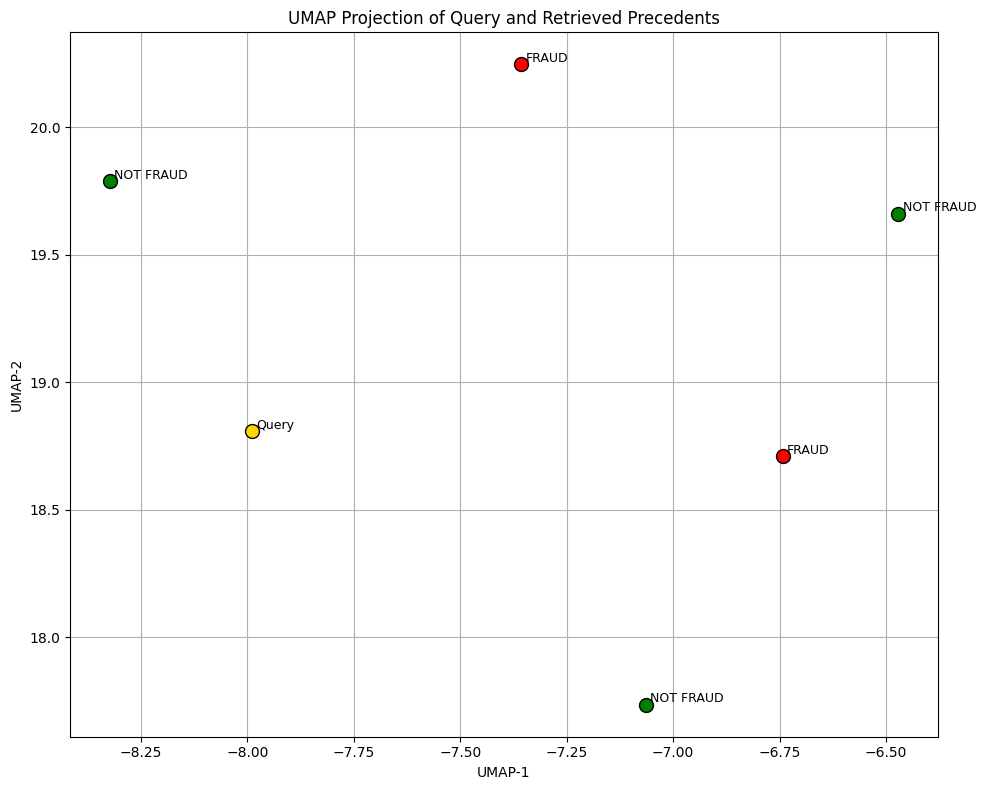

In [97]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

# Use the same transformer as in your notebook
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define query transaction and precedents as full unstructured strings
query_text = (
    "trans_date_trans_time=2020-08-27 02:45:32, cc_num=3563837241599446, "
    "merchant=Auer-Mosciski, category=grocery_pos, amt=306.41, first=Timothy, "
    "last=Simmons, gender=M, street=1049 John Ports Suite 057, city=Newberg, "
    "state=OR, zip=97132, lat=45.31, long=-122.97, city_pop=28278, job=Research scientist "
    "(physical sciences), dob=1977-07-17, trans_num=eee887c490e3baeeb42b371be4fc8ac7, "
    "unix_time=1377571532, merch_lat=45.27, merch_long=-122.05"
)

precedents = [
    "Distance: 0.202; trans_date_trans_time: 2020-08-27 11:43:19; cc_num: 3563837241599446; "
    "merchant: Hudson-Ratke; category: grocery_pos; amt: 286.88; first: Timothy; last: Simmons; "
    "gender: M; street: 1049 John Ports Suite 057; city: Newberg; state: OR; zip: 97132; "
    "lat: 45.3099; long: -122.9685; city_pop: 28278; job: Research scientist (physical sciences); "
    "dob: 1977-07-17; trans_num: b14c5bee2dac72b513ed268a379a1c66; unix_time: 1377603799; "
    "merch_lat: 46.102963; merch_long: -123.3777; is_fraud: 1",

    "Distance: 1.168; trans_date_trans_time: 2020-08-21 05:08:09; cc_num: 180046165512893; "
    "merchant: Stiedemann Ltd; category: food_dining; amt: 192.74; first: Erica; last: Walker; "
    "gender: F; street: 084 Holmes Avenue Suite 206; city: Stayton; state: OR; zip: 97383; "
    "lat: 44.8021; long: -122.7624; city_pop: 9587; job: Engineer, biomedical; "
    "dob: 1968-03-24; trans_num: ad40cdc85ad18b0abe5207adc53ff665; unix_time: 1377061689; "
    "merch_lat: 44.20844; merch_long: -122.573671; is_fraud: 0",

    "Distance: 1.359; trans_date_trans_time: 2020-08-27 00:50:04; cc_num: 3563837241599446; "
    "merchant: Raynor, Reinger and Hagenes; category: gas_transport; amt: 11.0; first: Timothy; "
    "last: Simmons; gender: M; street: 1049 John Ports Suite 057; city: Newberg; state: OR; "
    "zip: 97132; lat: 45.3099; long: -122.9685; city_pop: 28278; job: Research scientist "
    "(physical sciences); dob: 1977-07-17; trans_num: 6a4b3820a94c4aeebb685557fe02fc05; "
    "unix_time: 1377564604; merch_lat: 45.479046; merch_long: -122.89965; is_fraud: 1",

    "Distance: 1.408; trans_date_trans_time: 2020-07-20 13:00:04; cc_num: 3563837241599446; "
    "merchant: Dach-Nader; category: misc_net; amt: 10.18; first: Timothy; last: Simmons; "
    "gender: M; street: 1049 John Ports Suite 057; city: Newberg; state: OR; zip: 97132; "
    "lat: 45.3099; long: -122.9685; city_pop: 28278; job: Research scientist (physical sciences); "
    "dob: 1977-07-17; trans_num: 9e44fb4c58634b57d99192f999b72de4; unix_time: 1374325204; "
    "merch_lat: 45.421557; merch_long: -123.48094; is_fraud: 0",

    "Distance: 1.473; trans_date_trans_time: 2020-07-16 15:32:05; cc_num: 3563837241599446; "
    "merchant: Reichert, Rowe and Mraz; category: shopping_net; amt: 3.86; first: Timothy; "
    "last: Simmons; gender: M; street: 1049 John Ports Suite 057; city: Newberg; state: OR; "
    "zip: 97132; lat: 45.3099; long: -122.9685; city_pop: 28278; job: Research scientist "
    "(physical sciences); dob: 1977-07-17; trans_num: d57ffffcd74917bd34891f015ad7daa8; "
    "unix_time: 1373988725; merch_lat: 45.347613; merch_long: -122.51641399999998; is_fraud: 0"
]

# Combine for embedding
all_texts = [query_text] + precedents
embeddings = model.encode(all_texts)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Assign colors and labels
colors = ['gold', 'red', 'green', 'red', 'green', 'green']
labels = ['Query', 'FRAUD', 'NOT FRAUD', 'FRAUD', 'NOT FRAUD', 'NOT FRAUD']

# Plot
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, color=colors[i], s=100, edgecolors='black', zorder=3)
    plt.text(x + 0.01, y + 0.01, labels[i], fontsize=9)

plt.title("UMAP Projection of Query and Retrieved Precedents")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🌱 Future Directions and Tabled Ideas for Improvement

These ideas were identified as promising but intentionally deferred until a later stage of development:

- **Pattern Evidence Summary Injection:** Before the judge delivers a verdict, inject a concise, structured summary of key fraud indicators derived from precedent transactions (e.g., same cardholder, time proximity, similar amounts, geographic deviation). This provides the model with an evidence-based checklist that reinforces consistent and accurate rulings without relying solely on the quality of the debate text.

- **Hallucination Detection:** Automatically flag and analyze when the prosecutor or defender invents facts not grounded in the case.

- **Automatic Verdict Summarization:** Simplify the judge’s prose to highlight only the top 2–3 reasons for the ruling.

- **Fact-Checker Risk Score:** Create a numerical anomaly risk score based on the Fact-Checker report for statistical calibration.

- **Agent Retraining via RAG + Supervised Finetuning:** Use misclassified or high-risk cases to retrain agent behavior with reinforcement learning or distillation.

- **Agent Role Scorecarding:** Track per-agent precision/recall and use performance to guide strategic prompting or agent self-improvement.

- **Dynamic Prompt Calibration:** Automatically adjust prompt structure and verbosity to reduce LLM cutoff and hallucination risks.

- **Error-Driven Curriculum:** Weight harder, previously misclassified examples higher in future training cycles or testing.

These will be explored once the base system proves robust through initial testing and error analysis.
